# 共享单车数据集上的线性回归分析

## 导入必要的工具包

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## 读取数据并进行分割 (随机选择80%作为训练数据，剩下20%作为测试数据)

In [2]:
# 从文件读取数据
df = pd.read_csv('data/FE_day.csv')

# 从做好特征工程的数据中分割出X，y
X = df.drop(columns=['cnt','instant'])
# X = df.drop(columns=['cnt'])
y = df['cnt']

# 进一步分割出训练集和校验集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
print(X_train.shape, X_test.shape)

(584, 33) (147, 33)


## 训练最小二乘线性回归

In [3]:
# 创建实例
lr = LinearRegression()

# 训练模型
lr.fit(X_train, y_train)

# 分别在校验集和训练集上进行预测
y_lr_test_pred = lr.predict(X_test)
# y_lr_train_pred = lr.predict(X_train)

## 训练岭回归和Lasso

### 用默认alpha进行训练

In [4]:
# 创建实例
rc = RidgeCV() # RidgeCV的alphas默认设为[ 0.1  1.  10. ]
ls = LassoCV() # LassoCV的alphas默认设为None，模型会自动设置alpha

# 训练模型
rc.fit(X_train, y_train)
ls.fit(X_train, y_train)

# 输出拟合模型后得出的最优参数
print(rc.alpha_)
print(ls.alpha_)

1.0
1.5146214263573146


使用默认alphas参数，岭回归模型和Lasso模型得出的最优alpha分别是1.0和1.5，下一步则在它们附近进一步找更精确的值

### 超参数alpha调优
根据默认alphas参数得出的结果，在它们附近进一步找更精确的alpha值

In [5]:
# 将岭回归的alphas设在1.0附近
rc_alphas = np.arange(0.5, 1.5, 0.001)
# 将Lasso的alphas设在1.5附近
ls_alphas = np.arange(1.0, 2.0, 0.001)

# 创建实例
rc = RidgeCV(alphas=rc_alphas, store_cv_values=True) # store_cv_values参数设为True时将保存每个alphas对应的一组误差到cv_values_属性中
ls = LassoCV(alphas=ls_alphas)

# 训练模型
rc.fit(X_train, y_train)
ls.fit(X_train, y_train)

# 分别在校验集和训练集上进行预测
y_rc_test_pred = rc.predict(X_test)
# y_rc_train_pred = rc.predict(X_train)
y_ls_test_pred = ls.predict(X_test)
# y_ls_train_pred = ls.predict(X_train)

print(f'RidgeCV调优后的alpha结果：{rc.alpha_:.3f}')
print(f'LassoCV调优后的alpha结果：{ls.alpha_:.3f}')

RidgeCV调优后的alpha结果：0.987
LassoCV调优后的alpha结果：1.543


#### 可视化岭回归中不同alpha的误差

Text(0.8870000000000005, 599917.0369487497, 'optimal alpha: 0.987')

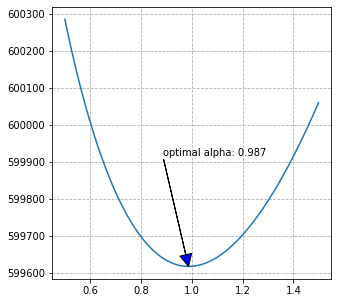

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# 画图
errors = rc.cv_values_.mean(axis=0)
plt.figure(figsize=(5,5))
plt.grid(ls='--')
plt.plot(rc_alphas, errors)


# 标注最小alpha的位置
min_error_idx = errors.argmin()
optimal_alpha = rc_alphas[min_error_idx]
min_error = errors[min_error_idx]
# plt.text(optimal_alpha, min_error, f'alpha: {rc_alphas[min_error_idx]:.3f}')
plt.annotate(f'optimal alpha: {optimal_alpha:.3f}', 
             xy=(optimal_alpha, min_error), 
             xytext=(optimal_alpha-0.1, min_error+300),
             arrowprops=dict(facecolor='blue', shrink=0, width=0))

In [7]:
rc.cv_values_[0,0:3]

array([1200974.85666336, 1201039.24893512, 1201103.64413847])

## 模型性能评估
用RMSE对模型进行性能评估

In [8]:
# 计算各个模型的RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_lr_test_pred))
rmse_rc = np.sqrt(mean_squared_error(y_test, y_rc_test_pred))
rmse_ls = np.sqrt(mean_squared_error(y_test, y_ls_test_pred))

print(f'最小二乘线性回归对应的RMSE为{rmse_lr:.3f}')
print(f'岭回归对应的RMSE为{rmse_rc:.3f}')
print(f'LASSO对应的RMSE为{rmse_ls:.3f}')

最小二乘线性回归对应的RMSE为857.293
岭回归对应的RMSE为855.053
LASSO对应的RMSE为859.009


对比三种模型得到的各个特征的系数

In [10]:
features_names = X.columns
df_coef = pd.DataFrame(dict(column=features_names, lr_coef=lr.coef_, rc_coef=rc.coef_, ls_coef=ls.coef_))
df_coef

,column,lr_coef,rc_coef,ls_coef
0,yr,2.053785e+03,2058.645163,2056.973815
1,season_1,-4.542393e+16,-958.614189,-1169.754693
2,season_2,-4.542393e+16,138.323349,0.000000
3,season_3,-4.542393e+16,86.315408,-54.961105
4,season_4,-4.542393e+16,733.975432,542.294062
5,mnth_1,-1.823947e+16,-319.821241,-166.992083
6,mnth_2,-1.823947e+16,-137.420627,-0.000000
7,mnth_3,-1.823947e+16,183.663785,226.256787
8,mnth_4,-1.823947e+16,17.661463,-0.000000
9,mnth_5,-1.823947e+16,289.506526,212.331202


总结：从上面的结果可以看出岭回归算法在测试集上的表现最好，岭回归和lasso回归都对参数有正则，让参数的浮动范围变小，并且lasso还会起到筛选特征的作用，上面的特征系数很多都是0，但是负面的作用就是利用的特征少了，更适用于特征维数过多，需要过滤掉某些相关性弱的特征的情况。